In [1]:
import os
import glob
import json
import geojson
import zipfile
import rasterio
import pyproj
import pathlib
import pandas
import numpy as np
from fastkml import  kml

import geopandas as gpd
import fiona
from shapely.geometry import shape
import rasterio.features
from rasterio import features
from rasterio.plot import show
from rasterio.merge import merge   
from rasterio.plot import show
from shutil import copyfile
from pathlib import Path
from shapely.geometry import Polygon, box, MultiPolygon
from shapely import geometry, wkt
from pprint import pprint, pformat
import matplotlib.pyplot as plt

from ccc_devkit.io.storage import StorageDriver

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
from terracatalogueclient import Catalogue 
from creodias_finder import query, download

**Inputs**

In [2]:

# Name of the AOI
name = "uk"

# AOI formatL: shp, geojson, kml etc.
format_aoi = "shp"

# Start and end date for S2 scenes
date_start, date_end= "20190101", "20201231"

# Value for reclassification
value_class = 101

# WorldCover - https://viewer.esa-worldcover.org/worldcover
name_wc, password_wc = "sulova", "Sulova327"

# Sentinel S2 - https://apihub.copernicus.eu/apihub
sentinel_user, sentinel_pw = "sulova327", "sulova327"

# Creodias Copernicus DEM(30m) - https://finder.creodias.eu/
creodias_user, creodias_pw = "ansu@dhigroup.com", "Sulova327"

# Directories for AOI, work directory, S2 tile Grid, polygons of specific crops
dir_AOI =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}/AOI")
dir_work =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}")
S2_Grid =  gpd.read_file('/ncr2420/ANSU/3_Data/S2-Tiles/sentinel2_tiles_world.shp')
dir_polygons =  pathlib.Path(f"/ncr2420/ANSU/6_Tasks/2110_ET/{name}/MS_Bounds/Field Bounds")


# 1. Merge all the AOI files

Number of files: 8
['/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/BC_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/Bubb_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/Daw_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/Elveden_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/GC_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/RASmith_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/Tern_FieldBnd.shp', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/Wharton_FieldBnd.shp']
shp


/home/jovyan/.conda/envs/py3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/AOI/merge.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver ESRI Shapefile does not support creation option ENCODING


[]

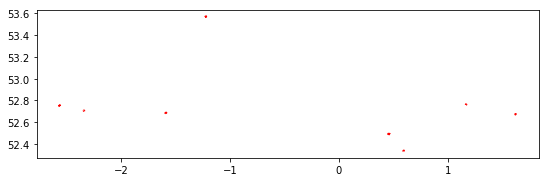

In [3]:

# Delete previous files in the aoi folder
    
if os.path.isfile(os.path.join(dir_AOI, f'merge.geojson')):
    os.remove(os.path.join(dir_AOI, f'merge.geojson'))
if os.path.isfile(os.path.join(dir_AOI, f'merge.shp')):
    os.remove(os.path.join(dir_AOI, f'merge.shp'))    

# Search for all files  
files = glob.glob(f'{dir_AOI}/*.{format_aoi}')
print('Number of files:',len(files))
print(files)

if (format_aoi == "shp" ):
    print("shp")
    for shp in files:
        gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
        
if (format_aoi == "kml" ):
    print("kml")
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    for shp in files:
        gdf_merge = pandas.concat([gpd.read_file(shp,driver='KML') for shp in files]).pipe(gpd.GeoDataFrame)
        
if (format_aoi == "geojson" ):
    print("geojson")
    for shp in files:
        gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
        
gdf_merge.crs = "EPSG:4326"

merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.geojson'), driver='GeoJSON')
merge_file = gdf_merge.to_file(os.path.join(dir_AOI, f'merge.shp'))

ax_AOI = gdf_merge.plot(figsize = (9,13),facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

# 1.1 Find the matching S2 tiles

In [4]:
# Intersection of the S2 tiles and AOI
intersection = gpd.overlay(S2_Grid, gdf_merge, how='intersection')
# Intersection of the S2 tiles and AOI
intersection

/home/jovyan/.conda/envs/py3/lib/python3.6/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and EPSG:4326
  other.crs))


,Name,name,geometry
0,30UWD,None,POLYGON Z ((-2.56634968233335 52.7478007492843...
1,30UWD,None,POLYGON Z ((-2.34289220707003 52.7037595601137...
2,30UWD,None,POLYGON Z ((-1.59331165846186 52.6814448216111...
3,30UXE,None,POLYGON Z ((-1.22724921464693 53.5672414925908...
4,30UYD,None,POLYGON Z ((0.467708195407399 52.4876610382605...
9,31UCU,None,POLYGON Z ((0.467708195407399 52.4876610382605...
5,30UYD,None,POLYGON Z ((0.594456716012383 52.3336790597574...
10,31UCU,None,POLYGON Z ((0.594456716012383 52.3336790597574...
6,30UYD,None,POLYGON Z ((1.16515614354908 52.7599461050998 ...
11,31UCU,None,POLYGON Z ((1.16515614354908 52.7599461050998 ...


['30UWD', '30UXE', '30UYD', '31UCU', '31UDU']


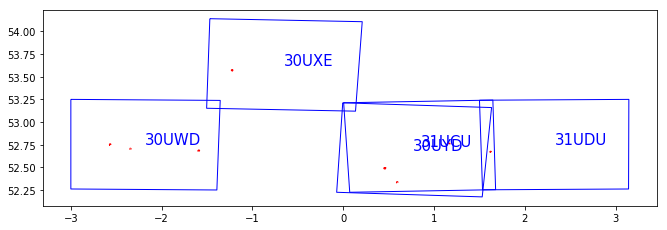

In [5]:
tiles_name = intersection['Name'].unique().tolist()
print(tiles_name)

# Plot of the S2 tiles and AOI
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})

ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})

for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)
    

# 1.2 Select S2 tiles 

In [6]:

# Select ID tiles which you wish to use further

#tiles_name = ['31UDU',"30UXE"]
tiles_name = ['30UWD','30UYD']


CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UYD.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/30UYD.geojson does not support layer creation option ENCODING


Saving the uk tile:/ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson  
Saving the uk tile:/ncr2420/ANSU/6_Tasks/2110_ET/uk/30UYD.geojson  


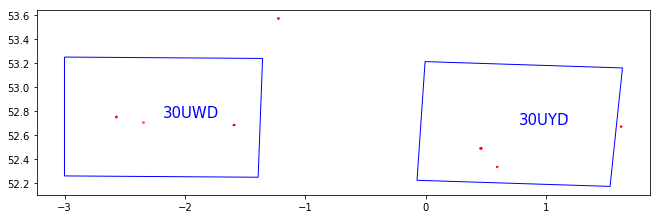

In [7]:

# Select S2 tiles within the AOI        
S2_Tile_Selection = S2_Grid[S2_Grid['Name'].isin(tiles_name)]

# Plot of the S2 tiles and AOI
S2_Tile_Plot = S2_Tile_Selection.plot(figsize = (11,16), facecolor="none", 
                                      edgecolor = 'blue', lw = 1, legend = True,
                                      legend_kwds = {'bbox_to_anchor':(0, 1.05),'fontsize':10,})
ax = gdf_merge.plot(ax = S2_Tile_Plot, facecolor = "none", lw = 2, edgecolor = 'red',legend = True, legend_kwds = {'bbox_to_anchor':(2, 1.05),'fontsize':15,})

for i, geo in S2_Tile_Selection.centroid.iteritems():
    ax.annotate(s=S2_Tile_Selection.Name[i], xy = [geo.x, geo.y], color="blue",fontsize = 15,)
    
# Save S2 tile as a geojson file
for index, row in S2_Tile_Selection.iterrows():
    name_s2 = row["Name"]
    polygon = S2_Tile_Selection.loc[S2_Tile_Selection['Name'] == name_s2]
    out_name = os.path.join(dir_work, "{0}.geojson".format(name_s2))
    print("Saving the {0} tile:{1}  ".format(name,out_name))
    polygon.to_file(out_name, driver='GeoJSON')
        


In [8]:
# Delete previous files in the folder
file_json = glob.glob(f'{dir_work}/tiles.geojson')
for f in file_json:
    if os.path.isfile(f):
        os.remove(f)
       
files = glob.glob(f'{dir_work}/*.geojson')
print('Number of files:',len(files))
print(files[:2])


gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files[:2]]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"

merge_file = gdf_merge.to_file(os.path.join(dir_work,'merge_tiles.geojson'), driver='GeoJSON')

Multi = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(os.path.join(dir_work,'merge_tiles.geojson'))])

out_merge = os.path.join(dir_work,f'{name}.geojson')
final =  gpd.GeoSeries([Multi]).to_file(out_merge, driver = 'GeoJSON')



CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/merge_tiles.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/merge_tiles.geojson does not support layer creation option ENCODING
CPLE_NotSupported in driver GeoJSON does not support creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/uk.geojson does not support layer creation option ENCODING
CPLE_NotSupported in dataset /ncr2420/ANSU/6_Tasks/2110_ET/uk/uk.geojson does not support layer creation option ENCODING


Number of files: 4
['/ncr2420/ANSU/6_Tasks/2110_ET/uk/30UWD.geojson', '/ncr2420/ANSU/6_Tasks/2110_ET/uk/30UYD.geojson']


# 1.3 S2 scenes


In [ ]:

#api_url='https://apihub.copernicus.eu/dhus'
api_url='https://scihub.copernicus.eu/dhus'

area = geojson_to_wkt(read_geojson(out_merge))

print(area)
output_file = os.path.join(dir_work, f"{name}_scenes_2019_2020.txt")

query_kwargs = {
    "platformname": "Sentinel-2",
    "producttype": "S2MSI1C",
    "cloudcoverpercentage": (0, 90),
    "date": (date_start, date_end),
    "tileid": area}

product = dict()
scenes = []

for tile in tiles_name:
    kw = query_kwargs.copy()
    kw["tileid"] = tile
    api = SentinelAPI(sentinel_user, sentinel_pw,api_url)
    api_product = api.query(**kw)
    dates = []
   
    for key, value in api_product.items():
        dates.append(value['datatakesensingstart'])
    dates = sorted(dates)[::-1]
    
    for d in dates:
        scenes.append({"date":f'{d:%Y-%m-%d}', 'tile':f'T{tile}'})

print(json.dumps(scenes))

with open(output_file, "w") as fp:
    fp.write(json.dumps(scenes, indent=1))
    

# 2. Copernicus DEM

In [ ]:

# Create a DEM folder 
dem_dir = os.path.join(dir_work,"DEM")

if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)   
    
dem_aoi = f"{dir_work}/{name}.geojson"

merge_gpd = gpd.read_file(dem_aoi)
bounds_AOI = merge_gpd.total_bounds
geometry = box(*bounds_AOI) 

results_update = []

results = query.query('CopDem', geometry =geometry)

for result in results.values():
    productType = result["properties"]["productType"]
    if productType == "SAR_DGE_30_PUBLIC":
        title = result["properties"]["title"]
        ids = result["id"]
        download_title= os.path.join(dem_dir,title)
        download_id = os.path.join(dem_dir,f"{ids}.zip")
        if not os.path.exists(download_id):
            results_update.append(ids)  

print("Number of downloads:", len(results_update))



In [ ]:
paths = download.download_list(list(results_update), creodias_user, creodias_pw, dem_dir,threads=10, show_progress=False)

DEM_tif = glob.glob(os.path.join(dem_dir,f"*.zip"))

for path in DEM_tif:
    with zipfile.ZipFile(path, "r") as z:
        z.extractall(dem_dir)
    os.remove(path)
    

In [ ]:

# Merge the selected tiles

DEM_tif = glob.glob(os.path.join(f"{dem_dir}/DEM1*/Copernicus*/DEM/","*.tif"))

src_files_to_mosaic = []

for fp in DEM_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
print("Number of downloads:", len(src_files_to_mosaic))  

mosaic, out_trans = merge(src_files_to_mosaic)    

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
    "height": mosaic.shape[1],"width": mosaic.shape[2],"transform": out_trans} )
with rasterio.open(f"{dir_work}/DEM.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
    

# 3. Land Cover - World Cover

In [ ]:

# Search and download the tiles for AOI from World Cover 

tileList = []

for tile in tiles_name:
    merge_gpd = gpd.read_file(f"{dir_work}/{tile}.geojson")
    bounds_AOI = merge_gpd.total_bounds
    geometry = box(*bounds_AOI)      
   
    # create catalogue object and authenticate 
    catalogue = Catalogue().authenticate() 
    catalogue = catalogue.authenticate_non_interactive(name_wc, password_wc) 
    
    # search for products in the WorldCover collection 
    products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry) 
    for c in products:        
        file_dir = f"{dir_work}/WorldCover/{title}"
        if not os.path.isdir(file_dir):
            print(f"{tile} - {title} file NOT exists")
            products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", geometry=geometry)
            catalogue.download_products(products, os.path.join(dir_work, f"WorldCover"), force=True)
        else:
            print(f"{tile} - {title} exists")
            

# 4. Reclassify Land Cover - World Cover

In [ ]:

# Merge all crop polygons together  

if os.path.isfile(os.path.join(dir_work, f'merge_polygons.geojson')):
    os.remove(os.path.join(dir_work, f'merge_polygon.geojson'))
if os.path.isfile(os.path.join(dir_work, f'merge_polygon.shp')):
    os.remove(os.path.join(dir_work, f'merge_polygon.shp'))   
    
files = glob.glob(f'{dir_polygons}/*.{format_aoi}')
print('Number of files:',len(files))

gdf_merge = pandas.concat([gpd.read_file(shp) for shp in files]).pipe(gpd.GeoDataFrame)
gdf_merge.crs = "EPSG:4326"

polygon_merge = os.path.join(dir_work, f'merge_polygon')
merge_file = gdf_merge.to_file(os.path.join(dir_work, f'crop_polygon.geojson'), driver='GeoJSON')
merge_file = gdf_merge.to_file(os.path.join(dir_work, f'crop_polygon.shp'))

ax_AOI = gdf_merge.plot(figsize = (9,13),facecolor = "none", lw = 2, edgecolor = 'red')
ax_AOI.plot()

print(polygon_merge)

In [ ]:

def rasterize_vector(gdf, profile, **kwargs):
    gdf = gdf.to_crs(profile['crs'])
    geoms = [g.__geo_interface__ for g in gdf.geometry.values]
    mask = rasterio.features.rasterize(
            geoms,
            out_shape=(profile['width'],profile['height']),
            transform=profile['transform'], fill= 0,
            **kwargs)
    return mask

def reclassified_mask(rasterfile, vectorfile, path ):
    with rasterio.open(rasterfile) as src_ras:
        data_down = src_ras.read(1)
        profile = src_ras.profile.copy()
            
    gdf = gpd.read_file(vectorfile)
   
    mask = rasterize_vector(gdf, profile)
    out_file = f'{path}/raster.tif'
    with rasterio.open(out_file, "w", **profile) as dst:
        dst.write(mask.astype(rasterio.uint8), 1)
    
    # Create classification
    with rasterio.open(out_file) as src_top:
        data_top = src_top.read(1)
        height, width = data_top.shape  
        profile = src_top.profile
        data = np.where(data_top==1, value_class, data_down)
    
    out_name = os.path.join(path,f'reclassify_LC.tif')
      
    with rasterio.open(out_name,'w', **profile) as dst_final:
        dst_final.write(data.astype(rasterio.uint8), 1)
        
    print(out_name)
    
    return out_name


In [ ]:

LC_tif = glob.glob(os.path.join(f"{dir_work}/WorldCover/*/","*Map.tif"))
src_files_to_mosaic = []

for fp in LC_tif:
    if not os.path.isfile(os.path.join(os.path.dirname(fp),"raster.tif")):
        print(os.path.dirname(os.path.realpath(fp)))
        reclassified_mask (fp, os.path.join(dir_work, f'crop_polygon.geojson'), os.path.dirname(fp))
    

In [ ]:

# Merge all tiles together 

LC_tif = glob.glob(os.path.join(f"{dir_work}/WorldCover/*/","reclassify_LC.tif"))
src_files_to_mosaic = []

for fp in LC_tif:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)   

mosaic, out_trans = merge(src_files_to_mosaic)

profile = src.profile.copy()

# out_meta = src.meta.copy()
profile.update({"driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    #"transform": out_trans
               } )

out_WorldCover  = f"{dir_work}/WorldCover.tif"

with rasterio.open(out_WorldCover, "w", **profile) as dest:
    dest.write(mosaic)
         

# 5. Copy constant files

In [ ]:
file_ads = ".adsapirc"
file_cds = ".cdsapirc"
file_flux = "fluxes_config_template"
file_Sen2Cor = "Sen2Cor_2.9.0_L2A_GIPP_template"

copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_ads}',os.path.join(dir_work, f"{file_ads}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_cds}"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_flux}.txt"))
copyfile(f'/ncr2420/ANSU/6_Tasks/2110_ET/_Template/{file_cds}',os.path.join(dir_work, f"{file_Sen2Cor}.xml"))

# 6. Azure Storage

In [ ]:
from ccc_devkit.io import azure_blob, filepaths
from ccc_devkit.logging.log import add_handlers

import subprocess
import logging

In [ ]:
logger = logging.getLogger("ccc")
logger.setLevel(logging.INFO)


In [ ]:
dir_work.upload(path_local=dir_work, path_upload=l2b_path)        )

In [ ]:
 sd = azure_blob.AzureStorageDriver()